# Inteligencia Artificial / Maestría MACC
## Miniproyecto 3: El Mundo de Wumpus
#### Presentado por: Juan David Rojas \& Oscar Velasco
#### Presentado a: Edgar José Andrade
### 29 de Noviembre de 2021

In [1]:
import cairosvg
import copy

import pandas as pd
import numpy as np
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

from itertools import product
from time import sleep, time
from IPython.display import clear_output;

from wumpus import *
from busqueda import *

gum.config['notebook','potential_visible_digits'] = 2

## Implementación Ambiente de Tarea

In [2]:
def maximo_aleatorio(valores):
    indices = [i for i, x in enumerate(valores) if x == max(valores)]
    return np.random.choice(indices)

In [3]:
def tomar_decision(casilla, evs, tabla=False, imagen=False):
    # Creamos la red de decision para la casilla dada
    model = crear_red_decision(casilla)
    # Guardamos solo la evidencia que cae en las variables de la red de decisión
    evid = {v:evs[v] for v in evs.keys() if v in model.names()}
    # Hacemos la inferencia
    ie = gum.InfluenceDiagramInference(model)
    ie.setEvidence(evid)
    ie.makeInference()
    casillas = [c for c in adyacentes(casilla)]
    valores = ie.posteriorUtility("Casilla")
    if tabla:
        print(valores)
    # Escogemos la acción con mayor utilidad esperada
    decision = maximo_aleatorio(valores.tolist())
    if imagen:
        svg = gnb.getInference(model,evs=evid,targets={})
        cairosvg.svg2png(bytestring=svg,write_to='inferencia.png',dpi=2000)
    return casillas[decision]

In [4]:
def tomar_decision(casilla, evs, tabla=False, imagen=False):
    # Creamos la red de decision para la casilla dada
    model = crear_red_decision(casilla)
    # Guardamos solo la evidencia que cae en las variables de la red de decisión
    evid = {v:evs[v] for v in evs.keys() if v in model.names()}
    # Hacemos la inferencia
    ie = gum.InfluenceDiagramInference(model)
    ie.setEvidence(evid)
    ie.makeInference()
    casillas = [c for c in adyacentes(casilla)]
    valores = ie.posteriorUtility("Casilla")
    if tabla:
        print(valores)
    # Escogemos la acción con mayor utilidad esperada
    decision = maximo_aleatorio(valores.tolist())
    if imagen:
        svg = gnb.getInference(model,evs=evid,targets={})
        cairosvg.svg2png(bytestring=svg,write_to='inferencia.png',dpi=2000)
    return casillas[decision]

In [5]:
def programa_utility_based(self, evidencia, casillas_seguras):
       
    # Encuentra la casilla actual
    casilla_actual = self.mundo.heroe
    acciones = []
    percepcion = self.percibir()
    
    # Si ve el oro, lo toma y planea un camino hasta la salida
    if 'brillo' in percepcion:
        # print("¡Veo el oro!")
        acciones = ['agarrar']
        R = Rejilla(casilla_actual, (0,0), casillas_seguras)
        camino = best_first_search(R)
        camino = [casilla_actual] + solucion(camino)
        acciones += acciones_camino(camino, self.mundo.direccion)
        
    # Si está en la salida y tiene el oro, salir
    elif self.mundo.heroe == (0,0) and self.mundo.oro_tomado:
        acciones.append('salir')
    else:
        # Escoje la casilla de mayor utilidad
        casilla_ir = tomar_decision(casilla_actual, evidencia)
        camino = [casilla_actual, casilla_ir]
        acciones += acciones_camino(camino, self.mundo.direccion)

    return acciones

setattr(Agente, "programa", programa_utility_based)

In [6]:
def crear_red_decision(cas):
    model = gum.InfluenceDiagram()
    todas_casillas = [(x,y) for x in range(4) for y in range(4)]
    total_casillas = len(todas_casillas)
    casillas = adyacentes(cas)
    num_casillas = len(casillas)

    # Creando variables del oro, brisas, pozos, wumpus y hedores
    oro = gum.LabelizedVariable('Oro','Oro',total_casillas)
    for i, c in enumerate(todas_casillas):
        oro.changeLabel(i,str(c))
        brillo_i = gum.LabelizedVariable('Brillo'+str(c),'Brillo'+str(c),2)
        model.addChanceNode(brillo_i)
        pozo_i = gum.LabelizedVariable('Pozo'+str(c),'Pozo'+str(c),2)
        model.addChanceNode(pozo_i)
        brisa_i = gum.LabelizedVariable('Brisa'+str(c),'Brisa'+str(c),2)
        model.addChanceNode(brisa_i)
        wumpus_i = gum.LabelizedVariable('Wumpus'+str(c),'Wumpus'+str(c),2)
        model.addChanceNode(wumpus_i)
        hedor_i = gum.LabelizedVariable('Hedor'+str(c),'Hedor'+str(c),2)
        model.addChanceNode(hedor_i)
    model.addChanceNode(oro)

    # Creando variables de casilla
    casilla = gum.LabelizedVariable('Casilla','Casilla a moverse',num_casillas)
    for i, c in enumerate(casillas):
        casilla.changeLabel(i,str(c))
    model.addDecisionNode(casilla)

    # Creando variable de utilidad
    ut_casilla = gum.LabelizedVariable('UtilityOfCasilla','Valor casilla',1)
    model.addUtilityNode(ut_casilla)

    # Creando aristas del grafo
    for c in todas_casillas:
        model.addArc('Oro', 'Brillo'+str(c))
        for c1 in adyacentes(c):
            model.addArc('Pozo'+str(c), 'Brisa'+str(c1))
            model.addArc('Wumpus'+str(c), 'Hedor'+str(c1))
    for c in casillas:
        model.addArc('Pozo'+str(c), 'UtilityOfCasilla')
        model.addArc('Wumpus'+str(c), 'UtilityOfCasilla')
    model.addArc('Oro', 'UtilityOfCasilla')
    model.addArc('Casilla', 'UtilityOfCasilla')
    
    # Creando tablas de probabilidad
    model.cpt('Oro').fillWith([1/total_casillas]*total_casillas)
    for c in todas_casillas:
        brillo = 'Brillo' + str(c)
        for c1 in todas_casillas:
            model.cpt(brillo)[{'Oro': str(c1)}] = oro_a_brillo(c,c1)
    
    pozos = ['Pozo'+str(c) for c in todas_casillas]
    for pozo in pozos:
        model.cpt(pozo)[:]=[0.8,0.2]
        
    wumpus = ['Wumpus'+str(c) for c in todas_casillas]
    for wump in wumpus:
        model.cpt(wump)[:]=[0.9,0.1]

    for c in todas_casillas:
        pozos_brisa = ['Pozo'+str(c1) for c1 in adyacentes(c)]
        brisa = 'Brisa' + str(c)
        wumpus_hedor = ['Wumpus'+str(c1) for c1 in adyacentes(c)]
        hedor = 'Hedor' + str(c)
        
        opciones = list(product(*[[0,1] for p in pozos_brisa]))
        dicts_variables = [{pozos_brisa[i]:op[i] for i in range(len(pozos_brisa))} for op in opciones]
        for d in dicts_variables:
            model.cpt(brisa)[d] = pozos_a_brisa(d)
        
        opciones = list(product(*[[0,1] for p in wumpus_hedor]))
        dicts_variables = [{wumpus_hedor[i]:op[i] for i in range(len(wumpus_hedor))} for op in opciones]
        for d in dicts_variables:
            model.cpt(hedor)[d] = wumpus_a_hedor(d)
        
        
    # Creando la utilidad
    pozos = ['Pozo'+str(c) for c in casillas]
    wumpus = ['Wumpus'+str(c) for c in casillas]
    casillas = [str(c) for c in adyacentes(cas)]
    todas_casillas = [str(c) for c in todas_casillas]
    variables = ['Casilla','Oro'] + pozos + wumpus
    opciones = list(product(casillas, todas_casillas, *[[0,1] for i in pozos + wumpus]))
    dicts_variables = [{variables[i]:op[i] for i in range(len(variables))} for op in opciones]
    for d in dicts_variables:
        model.utility('UtilityOfCasilla')[d]=utilidad(d)
    
    return model


def pozos_a_brisa(d):
    if 1 not in d.values():
        return [1,0]
    else:
        return [0,1]
    

def wumpus_a_hedor(d):
    if 1 not in d.values():
        return [1,0]
    else:
        return [0,1]


def oro_a_brillo(c1,c2):
    if c1 == c2:
        return [0,1]
    else:
        return [1,0]
    

def utilidad(d):
    C = d['Casilla']
    if (d['Wumpus'+str(C)] == 0) and (d['Pozo'+str(C)] == 0) and (d['Oro'] == C):
        return 2
    elif (d['Wumpus'+str(C)] == 0) and (d['Pozo'+str(C)] == 0):
        return 0
    elif (d['Wumpus'+str(C)] == 1) and (d['Pozo'+str(C)] == 0):
        return -1
    elif (d['Wumpus'+str(C)] == 0) and (d['Pozo'+str(C)] == 1):
        return -3
    else:
        return -5

In [7]:
def jugar(W, turnos = 70, animar = False):
    pozos = 0
    wumpus = 0
    todas_casillas = [(x,y) for x in range(4) for y in range(4)]
    W.pintar_todo()
    agente = Agente(W)
    max_turnos = turnos
    acciones = []
    casillas_seguras = []
    evidencia = {'Pozo(0, 0)': 0, 'Wumpus(0, 0)': 0}
    for t in range(max_turnos):
        sleep(.25)
        casilla_actual = agente.mundo.heroe
        if casilla_actual not in casillas_seguras:
            casillas_seguras.append(casilla_actual)
        for casilla in casillas_seguras:
            evidencia['Pozo'+str(casilla)] = 0
            evidencia['Wumpus'+str(casilla)] = 0
        percepcion = agente.percibir()
        if 'brillo' not in percepcion:
            evidencia['Brillo'+str(casilla_actual)] = 0
        if 'brisa' in percepcion:
            evidencia['Brisa'+str(casilla_actual)] = 1
            if pozos < 2:
                model = crear_red_decision(casilla_actual)
                ie = gum.InfluenceDiagramInference(model)
                ie.setEvidence(evidencia)
                ie.makeInference()
                for casilla in adyacentes(casilla_actual):
                    if "Pozo"+str(casilla) not in evidencia.keys():
                        if ie.posterior("Pozo"+str(casilla))[1]>0.95:
                            evidencia["Pozo"+str(casilla)] = 1
                            pozos += 1
            else:
                for casilla in todas_casillas:
                    if "Pozo"+str(casilla) not in evidencia.keys():
                        evidencia["Pozo"+str(casilla)] = 0
        else:
            evidencia['Brisa'+str(casilla_actual)] = 0
            for casilla in adyacentes(casilla_actual):
                evidencia['Pozo'+str(casilla)] = 0
        if 'hedor' in percepcion:
            evidencia['Hedor'+str(casilla_actual)] = 1
            if wumpus < 1:
                model = crear_red_decision(casilla_actual)
                ie = gum.InfluenceDiagramInference(model)
                ie.setEvidence(evidencia)
                ie.makeInference()
                for casilla in adyacentes(casilla_actual):
                    if "Wumpus"+str(casilla) not in evidencia.keys():
                        if ie.posterior("Wumpus"+str(casilla))[1]>0.95:
                            x_wumpus, y_wumpus = casilla
                            x_heroe, y_heroe = casilla_actual
                            if ((x_heroe < x_wumpus) and (y_heroe == y_wumpus)):
                                matar = voltear(W.direccion, 'este') + ['disparar']
                            elif ((x_heroe > x_wumpus) and (y_heroe == y_wumpus)):
                                matar = voltear(W.direccion, 'oeste') + ['disparar']
                            elif ((y_heroe < y_wumpus) and (x_heroe == x_wumpus)):
                                matar = voltear(W.direccion, 'norte') + ['disparar']
                            else:
                                matar = voltear(W.direccion, 'sur') + ['disparar']
                            for i in matar:
                                W.transicion(i)
                                if animar:
                                    clear_output(wait=True)
                                    W.pintar_todo()
                                    plt.show()
                            if W.grito:
                                W.puntaje += 1000
                                for i in evidencia.keys():
                                    if "Hedor" in i:
                                        evidencia[i]=0
        else:
            evidencia['Hedor'+str(casilla_actual)] = 0
            for casilla in adyacentes(casilla_actual):
                evidencia['Wumpus'+str(casilla)] = 0
        if len(acciones) > 0:
            accion = acciones.pop(0)
        else:
            acciones = agente.programa(evidencia, casillas_seguras)
            accion = acciones.pop(0)
        W.transicion(accion)
        if not W.juego_activo:
            # clear_output(wait=True)
            # print(W.mensaje)
            break
        if animar:
            clear_output(wait=True)
            W.pintar_todo()
            plt.show()
    
    return evidencia

## Solución del Problema

### 1er Mundo

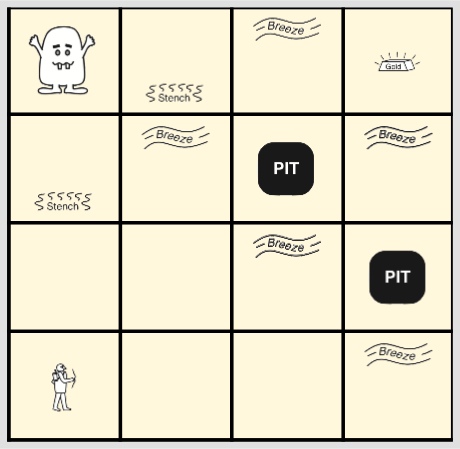

In [8]:
W1 = Wumpus(wumpus=(0,3), oro=(3,3), pozos=[(3,1), (2,2)])
W1.pintar_todo();

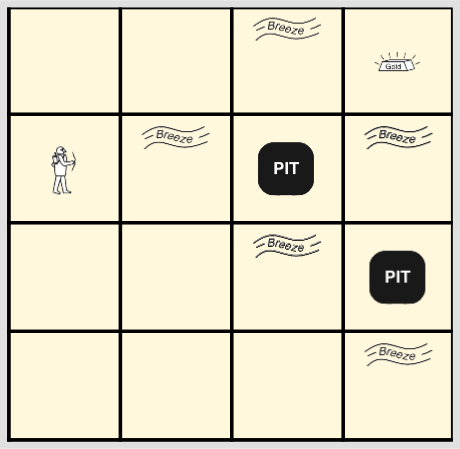

In [ ]:
jugar(W1, animar = True);

In [ ]:
W1.juego_activo, W1.oro_tomado, W1.puntaje

(True, False, 923)

### 2do Mundo


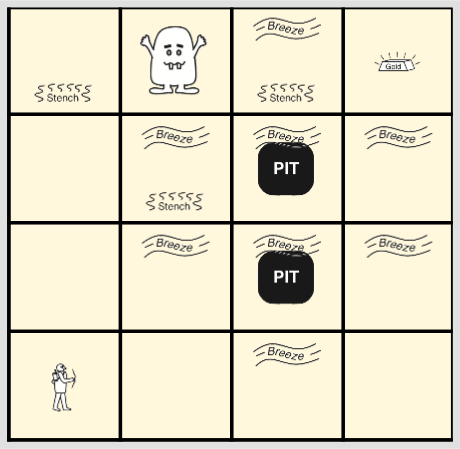

In [9]:
W2 = Wumpus(wumpus=(1,3), oro=(3,3), pozos=[(2,1), (2,2)])
W2.pintar_todo();

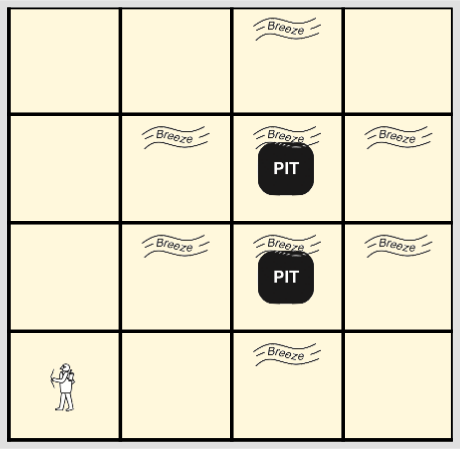

¡Juego terminado!
Puntaje: 1959


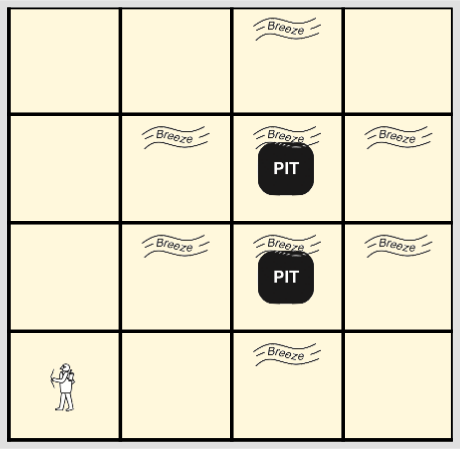

In [ ]:
jugar(W2, animar = True);

In [ ]:
W2.juego_activo, W2.oro_tomado, W2.puntaje

(False, True, 1959)

### 3er Mundo

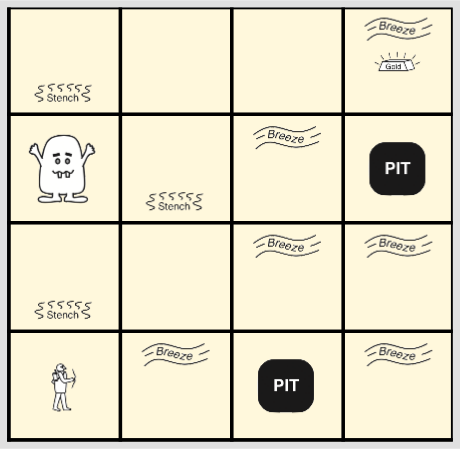

In [10]:
W3 = Wumpus(wumpus=(0,2), oro=(3,3), pozos=[(2,0), (3,2)])
W3.pintar_todo();

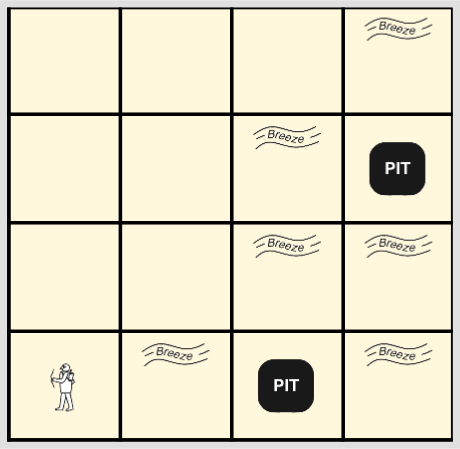

¡Juego terminado!
Puntaje: 1931


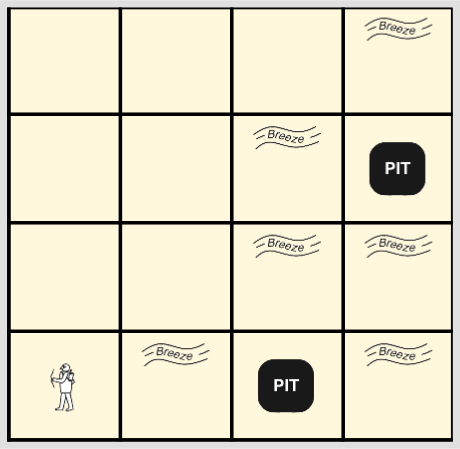

In [ ]:
jugar(W3, animar = True);

In [ ]:
W3.juego_activo, W3.oro_tomado, W3.puntaje

(False, True, 1931)

### 4to Mundo

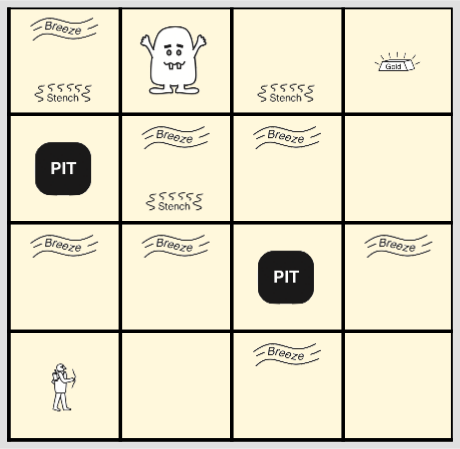

In [11]:
W4 = Wumpus(wumpus=(1,3), oro=(3,3), pozos=[(2,1), (0,2)])
W4.pintar_todo();

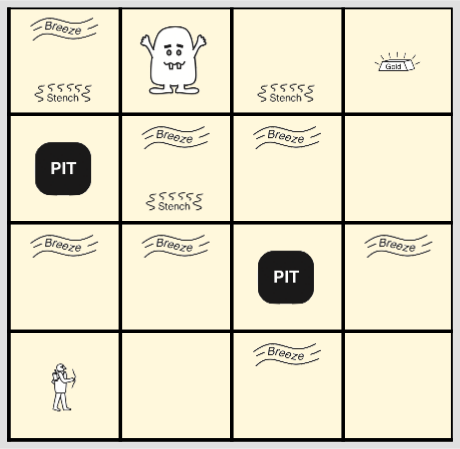

In [ ]:
jugar(W4, animar = True);

In [ ]:
W4.juego_activo, W4.oro_tomado, W4.puntaje

(True, False, -70)

### 5to Mundo

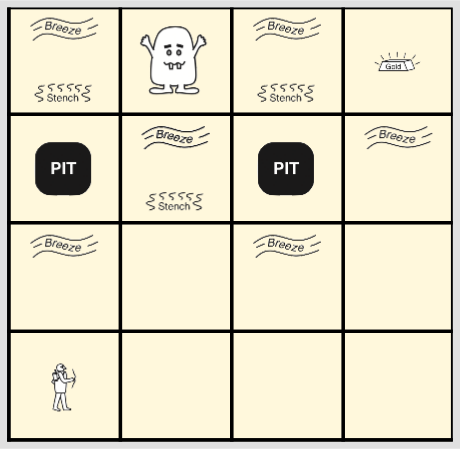

In [12]:
W5 = Wumpus(wumpus=(1,3), oro=(3,3), pozos=[(2,2), (0,2)])
W5.pintar_todo();

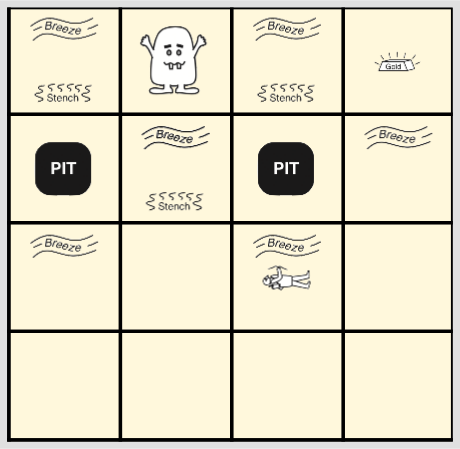

In [ ]:
jugar(W5, animar = True);

In [ ]:
W5.juego_activo, W5.oro_tomado, W5.puntaje

(True, False, -70)

### 6to Mundo

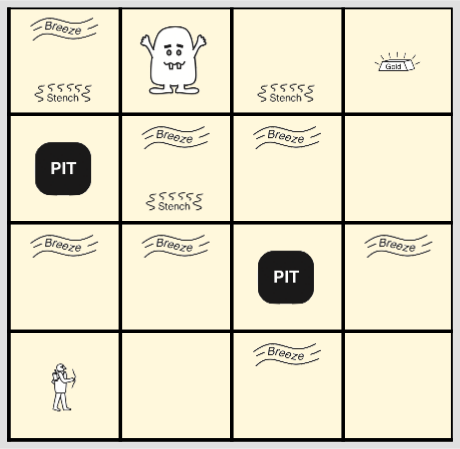

In [13]:
W6 = Wumpus(wumpus=(1,3), oro=(3,3), pozos=[(2,1), (0,2)])
W6.pintar_todo();

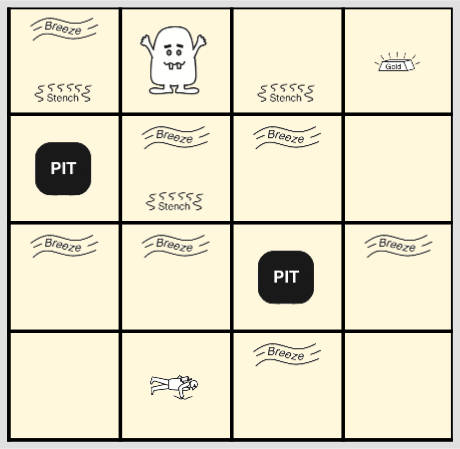

In [ ]:
jugar(W6, animar = True);

In [ ]:
W6.juego_activo, W6.oro_tomado, W6.puntaje

(True, False, -70)

## Analítica para los 6 primeros Mundos

In [ ]:
%%capture
rondas = 10
turnos = 80
tiempos = []
resultados = []
puntajes = []
wpvivos = []
W1 = Wumpus(wumpus=(0,3), oro=(3,3), pozos=[(3,1), (2,2)])
W2 = Wumpus(wumpus=(1,3), oro=(3,3), pozos=[(2,1), (2,2)])
W3 = Wumpus(wumpus=(0,2), oro=(3,3), pozos=[(2,0), (3,2)])
W4 = Wumpus(wumpus=(1,3), oro=(3,3), pozos=[(2,1), (0,2)])
W5 = Wumpus(wumpus=(1,3), oro=(3,3), pozos=[(2,2), (0,2)])
W6 = Wumpus(wumpus=(1,3), oro=(3,3), pozos=[(2,1), (0,2)])
mundos = [copy.copy(W1), copy.copy(W2), copy.copy(W3), copy.copy(W4), copy.copy(W5), copy.copy(W6)]
for i in range(rondas):
    print("Ronda:", i + 1)
    tiempo = []
    resultado = []
    puntaje = []
    wpvivo = []
    cont = 0
    for m in mundos:
        print("\tMundo:", cont + 1)
        mundo = copy.copy(m)
        begin = time()
        evsm = jugar(mundo, turnos = turnos);
        end = time()
        tiempo.append(end - begin)
        puntaje.append(mundo.puntaje)
        wpvivo.append(mundo.wumpus_vivo)
        if(not mundo.juego_activo and mundo.oro_tomado):
            resultado.append('W')
        elif(mundo.juego_activo):
            resultado.append('T')
        elif(not mundo.juego_activo and not mundo.oro_tomado):
            resultado.append('L')
        cont += 1
    tiempos.append(tiempo)
    puntajes.append(puntaje)
    resultados.append(resultado)
    wpvivos.append(wpvivo)

# 10 rondas en aprox 60min
# 3 rondas en aprox 20min
# 1 ronda en aprox 6min

In [ ]:
for t in tiempos:
    print(t)

[67.85020160675049, 22.897116661071777, 19.629926681518555, 61.870129108428955, 45.191712379455566, 67.57113695144653]
[42.04834580421448, 107.08758306503296, 17.108760833740234, 90.29966020584106, 53.707935094833374, 93.24291372299194]
[66.1245653629303, 58.179529428482056, 66.09206771850586, 82.31357765197754, 37.932425022125244, 54.132314682006836]
[78.2944073677063, 84.80130410194397, 45.54344034194946, 53.51760816574097, 58.66079306602478, 62.133869886398315]
[86.01555848121643, 81.68043422698975, 73.64661955833435, 53.80884337425232, 51.69339108467102, 57.57689189910889]
[96.43865585327148, 22.933202743530273, 67.9364538192749, 47.70167422294617, 72.45260763168335, 40.85522437095642]
[88.42649936676025, 74.88688158988953, 51.40580773353577, 57.764042139053345, 26.271867036819458, 55.9502067565918]
[68.88455367088318, 94.99324417114258, 18.95661234855652, 54.411208391189575, 68.88409113883972, 112.56041216850281]
[85.35370182991028, 22.596678256988525, 74.68978500366211, 32.323907

In [ ]:
for p in puntajes:
    print(p)

[-80, 1965, 1970, 918, 1951, 930]
[1933, -80, 1969, -80, 1943, 1918]
[919, 1933, 1953, -80, 1951, 1940]
[1918, 1918, 1961, 918, 1935, -80]
[918, 1937, 918, 940, 1931, 1931]
[918, 1965, 1918, 948, -80, 940]
[1925, 918, 1931, 922, 1961, 936]
[918, 918, 1970, 920, 1925, 920]
[-80, 1965, 1919, 954, 1927, -80]
[1941, 1957, 1957, -80, 958, 1941]


In [ ]:
for r in resultados:
    print(r)

['T', 'W', 'W', 'T', 'W', 'W']
['W', 'T', 'W', 'T', 'W', 'T']
['T', 'W', 'W', 'T', 'W', 'W']
['T', 'T', 'W', 'T', 'W', 'T']
['T', 'W', 'T', 'W', 'W', 'W']
['T', 'W', 'T', 'W', 'T', 'W']
['W', 'T', 'W', 'W', 'W', 'W']
['T', 'T', 'W', 'T', 'W', 'T']
['T', 'W', 'T', 'W', 'W', 'T']
['W', 'W', 'W', 'T', 'W', 'W']


In [ ]:
for wpv in wpvivos:
    print(wpv)

[True, False, False, False, False, True]
[False, True, False, True, False, False]
[False, False, False, True, False, False]
[False, False, False, False, False, True]
[False, False, False, True, False, False]
[False, False, False, True, True, True]
[False, False, False, True, False, True]
[False, False, False, True, False, True]
[True, False, False, True, False, True]
[False, False, False, True, True, False]


In [ ]:
w1 = pd.DataFrame()
w1['Tiempo'] = [i[0] for i in tiempos]
w1['Puntaje'] = [i[0] for i in puntajes]
w1['Resultado'] = [i[0] for i in resultados]
w1['Wumpus'] = [i[0] for i in wpvivos]
w1.index = w1.index + 1
w1.head() 

,Tiempo,Puntaje,Resultado,Wumpus
1,67.850202,-80,T,True
2,42.048346,1933,W,False
3,66.124565,919,T,False
4,78.294407,1918,T,False
5,86.015558,918,T,False


In [ ]:
w2 = pd.DataFrame()
w2['Tiempo'] = [i[1] for i in tiempos]
w2['Puntaje'] = [i[1] for i in puntajes]
w2['Resultado'] = [i[1] for i in resultados]
w2['Wumpus'] = [i[1] for i in wpvivos]
w2.index = w2.index + 1
w2.head() 

,Tiempo,Puntaje,Resultado,Wumpus
1,22.897117,1965,W,False
2,107.087583,-80,T,True
3,58.179529,1933,W,False
4,84.801304,1918,T,False
5,81.680434,1937,W,False


In [ ]:
w3 = pd.DataFrame()
w3['Tiempo'] = [i[2] for i in tiempos]
w3['Puntaje'] = [i[2] for i in puntajes]
w3['Resultado'] = [i[2] for i in resultados]
w3['Wumpus'] = [i[2] for i in wpvivos]
w3.index = w3.index + 1
w3.head() 

,Tiempo,Puntaje,Resultado,Wumpus
1,19.629927,1970,W,False
2,17.108761,1969,W,False
3,66.092068,1953,W,False
4,45.543440,1961,W,False
5,73.646620,918,T,False


In [ ]:
w4 = pd.DataFrame()
w4['Tiempo'] = [i[3] for i in tiempos]
w4['Puntaje'] = [i[3] for i in puntajes]
w4['Resultado'] = [i[3] for i in resultados]
w4['Wumpus'] = [i[3] for i in wpvivos]
w4.index = w4.index + 1
w4.head() 

,Tiempo,Puntaje,Resultado,Wumpus
1,61.870129,918,T,False
2,90.299660,-80,T,True
3,82.313578,-80,T,True
4,53.517608,918,T,False
5,53.808843,940,W,True


In [ ]:
w5 = pd.DataFrame()
w5['Tiempo'] = [i[4] for i in tiempos]
w5['Puntaje'] = [i[4] for i in puntajes]
w5['Resultado'] = [i[4] for i in resultados]
w5['Wumpus'] = [i[4] for i in wpvivos]
w5.index = w5.index + 1
w5.head() 

,Tiempo,Puntaje,Resultado,Wumpus
1,45.191712,1951,W,False
2,53.707935,1943,W,False
3,37.932425,1951,W,False
4,58.660793,1935,W,False
5,51.693391,1931,W,False


In [ ]:
w6 = pd.DataFrame()
w6['Tiempo'] = [i[5] for i in tiempos]
w6['Puntaje'] = [i[5] for i in puntajes]
w6['Resultado'] = [i[5] for i in resultados]
w6['Wumpus'] = [i[5] for i in wpvivos]
w6.index = w6.index + 1
w6.head() 

,Tiempo,Puntaje,Resultado,Wumpus
1,67.571137,930,W,True
2,93.242914,1918,T,False
3,54.132315,1940,W,False
4,62.133870,-80,T,True
5,57.576892,1931,W,False


In [ ]:
ws = pd.DataFrame()
ws['Tiempo'] = tiempos
ws['Puntaje'] = puntajes
ws['Resultado'] = resultados
ws['Wumpus'] = wpvivos
ws.index = ws.index + 1
ws.head() 

,Tiempo,Puntaje,Resultado,Wumpus
1,"[67.85020160675049, 22.897116661071777, 19.629...","[-80, 1965, 1970, 918, 1951, 930]","[T, W, W, T, W, W]","[True, False, False, False, False, True]"
2,"[42.04834580421448, 107.08758306503296, 17.108...","[1933, -80, 1969, -80, 1943, 1918]","[W, T, W, T, W, T]","[False, True, False, True, False, False]"
3,"[66.1245653629303, 58.179529428482056, 66.0920...","[919, 1933, 1953, -80, 1951, 1940]","[T, W, W, T, W, W]","[False, False, False, True, False, False]"
4,"[78.2944073677063, 84.80130410194397, 45.54344...","[1918, 1918, 1961, 918, 1935, -80]","[T, T, W, T, W, T]","[False, False, False, False, False, True]"
5,"[86.01555848121643, 81.68043422698975, 73.6466...","[918, 1937, 918, 940, 1931, 1931]","[T, W, T, W, W, W]","[False, False, False, True, False, False]"


In [ ]:
# Tiempo promedio en cada mundo
t_m = [round(np.mean(k), 3) for k in zip(*ws['Tiempo'])]
t_m

[71.777, 60.793, 47.639, 63.176, 52.783, 64.891]

In [ ]:
# Tiempo promedio en cada mundo
p_m = [np.mean(k) for k in zip(*ws['Puntaje'])]
p_m

[1123.0, 1539.6, 1846.6, 628.0, 1640.2, 1129.6]

In [ ]:
print(w1['Resultado'].value_counts())
print()
print(w1['Wumpus'].value_counts())

T    7
W    3
Name: Resultado, dtype: int64

False    8
True     2
Name: Wumpus, dtype: int64


In [ ]:
print(w2['Resultado'].value_counts())
print()
print(w2['Wumpus'].value_counts())

W    6
T    4
Name: Resultado, dtype: int64

False    9
True     1
Name: Wumpus, dtype: int64


In [ ]:
print(w3['Resultado'].value_counts())
print()
print(w3['Wumpus'].value_counts())

W    7
T    3
Name: Resultado, dtype: int64

False    10
Name: Wumpus, dtype: int64


In [ ]:
print(w4['Resultado'].value_counts())
print()
print(w4['Wumpus'].value_counts())

T    6
W    4
Name: Resultado, dtype: int64

True     8
False    2
Name: Wumpus, dtype: int64


In [ ]:
print(w5['Resultado'].value_counts())
print()
print(w5['Wumpus'].value_counts())

W    9
T    1
Name: Resultado, dtype: int64

False    8
True     2
Name: Wumpus, dtype: int64


In [ ]:
print(w6['Resultado'].value_counts())
print()
print(w6['Wumpus'].value_counts())

W    6
T    4
Name: Resultado, dtype: int64

True     6
False    4
Name: Wumpus, dtype: int64


## Problemas (El agente se queda encerrado por una frontera de Brisa)

### 7mo Mundo

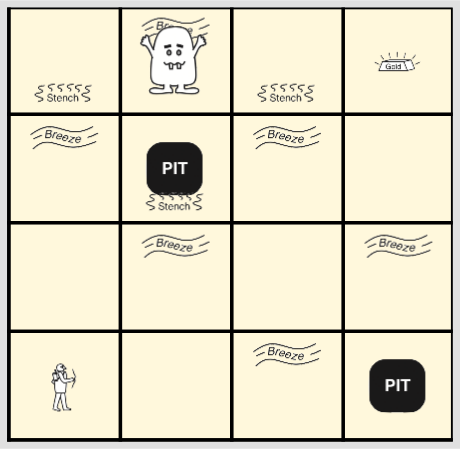

In [14]:
W7 = Wumpus(wumpus=(1,3), oro=(3,3), pozos=[(1,2), (3,0)])
W7.pintar_todo();

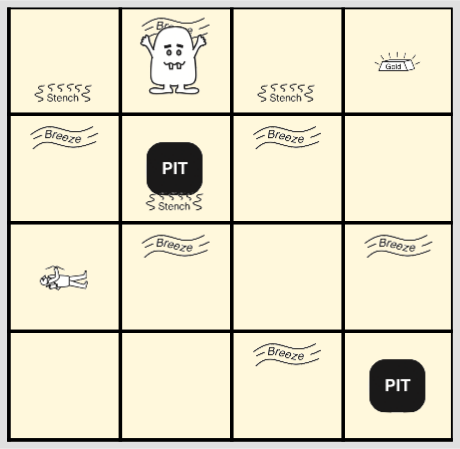

In [15]:
jugar(W7, animar = True);

In [16]:
W7.juego_activo, W7.oro_tomado, W7.puntaje

(True, False, -70)

### 8vo Mundo

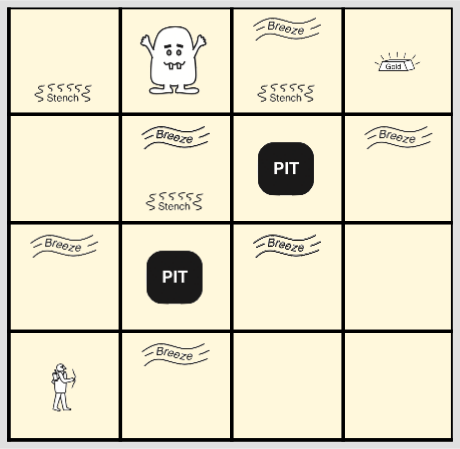

In [17]:
W8 = Wumpus(wumpus=(1,3), oro=(3,3), pozos=[(1,1), (2,2)])
W8.pintar_todo();

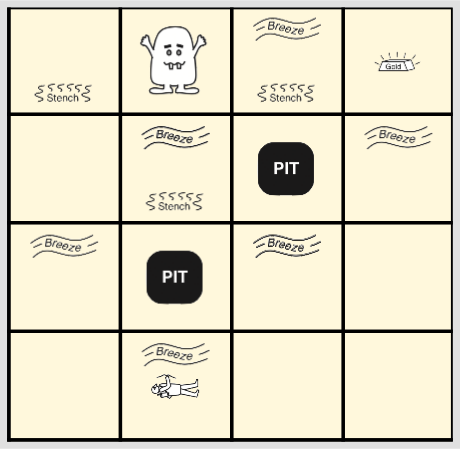

In [18]:
jugar(W8, animar = True);

In [19]:
W8.juego_activo, W8.oro_tomado, W8.puntaje

(True, False, -70)

Se deben plantear estrategias para evitar este tipo de "encierros".

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=aac42c09-c37e-4224-994e-665d09602642' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>